In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import fmin
from datetime import datetime
import yfinance as yf
import os
from scipy.stats import kurtosis
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from arch import univariate
import sys

In [31]:
# Download AORD data if needed
name_ao = 'ao_yf_2009_2021.csv'
if not os.path.isfile(name_ao):
    data_ao = yf.download("^AORD", start='2009-01-01', end='2021-10-23')
    data_ao.to_csv(name_ao)

data_ao = pd.read_csv(name_ao, index_col='Date', parse_dates=True, dayfirst=True)
r_ao = 100 * np.log(data_ao['Adj Close']).diff().dropna()
r_ao.head()

Date
2009-01-05   -0.460617
2009-01-06    1.372821
2009-01-07    1.051591
2009-01-08   -2.295330
2009-01-09    1.004918
Name: Adj Close, dtype: float64

In [32]:
# Last day of in-sample period
last_in = '2017-11-09'

# First day of forecasting period
frst_fc = '2017-11-10'

In [33]:
# For VaR calculations under Gaussian and Standardised-t distributions
def qn(p):
    return stats.norm.ppf(p)

def qt(p, df):
    return stats.t.ppf(p, df) * np.sqrt((df - 2) / df)

# GARCH

In [6]:
%%time
# Bad Implementation

n_fore = len(r_ao[frst_fc:])
n_wind = len(r_ao[:last_in])

old_var25_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
old_var1_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

garch = arch_model(r_ao, mean='Constant', vol='GARCH', p=1, q=1, dist='Normal')

for i in range(n_fore):
    if i % 20 == 0:
        garch_fit = garch.fit(first_obs=i, last_obs=(i + n_wind), disp="off")
    
    fc = garch_fit.forecast(horizon=1, align='target', reindex=False)
    
    temp25 = fc.mean + np.sqrt(fc.variance) * qn(0.025)
    temp1 = fc.mean + np.sqrt(fc.variance) * qn(0.01)
    
    old_var25_garch[i] = temp25.loc[old_var25_garch.index[i]]
    old_var1_garch[i] = temp1.loc[old_var1_garch.index[i]]

CPU times: user 5.01 s, sys: 67.3 ms, total: 5.08 s
Wall time: 5.16 s


In [7]:
%%time
# Good Implementation

n_fore = len(r_ao[frst_fc:])
n_wind = len(r_ao[:last_in])

garch = arch_model(r_ao, mean='Constant', vol='GARCH', p=1, q=1, dist='Normal')

var25_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

for i in range(n_fore):
    if i % 20 == 0:
        garch_fit = garch.fit(first_obs=i, last_obs=(i + n_wind), disp="off")
        
        fc = garch_fit.forecast(horizon=1, align='target', reindex=False)
    
        cached_temp25 = fc.mean + np.sqrt(fc.variance) * qn(0.025)
        cached_temp1 = fc.mean + np.sqrt(fc.variance) * qn(0.01)

    var25_garch[i] = cached_temp25.loc[var25_garch.index[i]]
    var1_garch[i] = cached_temp1.loc[var1_garch.index[i]]

CPU times: user 1.4 s, sys: 18.2 ms, total: 1.42 s
Wall time: 1.44 s


In [8]:
# Just to prove my method is the same as the tutorial
(old_var25_garch != var25_garch).sum()

0

### GARCH-t

In [9]:
%%time

n_fore = len(r_ao[frst_fc:])
n_wind = len(r_ao[:last_in])

garch_t = arch_model(r_ao, mean='Constant', vol='GARCH', p=1, q=1, dist='StudentsT')

var25_garch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_garch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

for i in range(n_fore):
    if i % 20 == 0:
        garch_t_fit = garch_t.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        
        fc = garch_t_fit.forecast(horizon=1, align='target', reindex=False)
        
        temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, garch_t_fit.params['nu'])
        temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, garch_t_fit.params['nu'])
    
    var25_garch_t[i] = temp25.loc[var25_garch_t.index[i]]
    var1_garch_t[i] = temp1.loc[var1_garch_t.index[i]]

CPU times: user 2.03 s, sys: 30.7 ms, total: 2.06 s
Wall time: 2.09 s


### EGARCH & EGARCH-t

In [10]:
%%time

n_fore = len(r_ao[frst_fc:])
n_wind = len(r_ao[:last_in])

egarch = arch_model(r_ao, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='Normal')
egarch_t = arch_model(r_ao, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='StudentsT')

var25_egarch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_egarch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_egarch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_egarch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

for i in range(n_fore):
    if i % 20 == 0:
        egarch_fit = egarch.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        egarch_t_fit = egarch_t.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        
        # EGARCH
        fc = egarch_fit.forecast(horizon=1, align='target', reindex=False)
        egarch_temp25 = fc.mean + np.sqrt(fc.variance) * qn(0.025)
        egarch_temp1 = fc.mean + np.sqrt(fc.variance) * qn(0.01)
        
        # EGARCH-t
        fc = egarch_t_fit.forecast(horizon=1, align='target', reindex=False)
        egarch_t_temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, egarch_t_fit.params['nu'])
        egarch_t_temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, egarch_t_fit.params['nu'])
        
    
    var25_egarch[i] = egarch_temp25.loc[var25_egarch.index[i]]
    var1_egarch[i] = egarch_temp1.loc[var1_egarch.index[i]]
    
    var25_egarch_t[i] = egarch_t_temp25.loc[var25_egarch_t.index[i]]
    var1_egarch_t[i] = egarch_t_temp1.loc[var1_egarch_t.index[i]]

CPU times: user 4.2 s, sys: 65.1 ms, total: 4.27 s
Wall time: 4.35 s


# CaVaR

In [13]:
from week12_helpers import caviar_loss, caviar_update

In [14]:
b02 = [-0.1, 0.8, -0.3]

In [15]:
%%time

n_fore = len(r_ao[frst_fc:])
n_wind = len(r_ao[:last_in])

var25_caviar = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_caviar = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

for i in range(n_fore):
    if i % 20 == 0:
        q025 = np.quantile(r_ao[i:(i + n_wind)], 0.025)
        q01 = np.quantile(r_ao[i:(i + n_wind)], 0.01)
        
        caviar25_par = fmin(caviar_loss, x0=b02, args=(r_ao[i:(i + n_wind)], 0.025, q025), disp=False)
        caviar1_par = fmin(caviar_loss, x0=b02, args=(r_ao[i:(i + n_wind)], 0.01, q01), disp=False)
        
        temp25 = caviar_update(caviar25_par, r_ao, 0.025, q025)
        temp1 = caviar_update(caviar1_par, r_ao, 0.01, q01)
        
    var25_caviar[i] = temp25.loc[var25_caviar.index[i]]
    var1_caviar[i] = temp1.loc[var1_caviar.index[i]]

CPU times: user 3min 32s, sys: 2.04 s, total: 3min 34s
Wall time: 3min 37s


### Historical

In [16]:
%%time

n_fore = len(r_ao[frst_fc:])
n_wind = len(r_ao[:last_in])

var25_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

for i in range(n_fore):
    var25_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].quantile(0.025)
    var1_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].quantile(0.01)

CPU times: user 1.27 s, sys: 17 ms, total: 1.29 s
Wall time: 1.3 s


### Risk Metrics

Their implementation takes 56 sec, mine takes 3 sec

In [17]:
from week12_helpers import igarch_update

In [18]:
%%time

# Bad Implementation
n_fore = len(r_ao[frst_fc:])
n_wind = len(r_ao[:last_in])

old_var25_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
old_var1_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

for i in range(n_fore):
    if i % 20 == 0:
        v0 = np.var(r_ao[i:(i + n_wind)])
        
    temp25 = np.sqrt(igarch_update(r_ao, v0)) * qn(0.025)
    temp1 = np.sqrt(igarch_update(r_ao, v0)) * qn(0.01)
    
    old_var25_rm[i] = temp25.loc[old_var25_rm.index[i]]
    old_var1_rm[i] = temp1.loc[old_var1_rm.index[i]]

/Users/jameschok/general_documents/tutoring/2021/2_semester/qbus6830/qbus6830_2021_sem2/week12_helpers.py:78: UserWarning: THIS SHOULD ONLY BE USED IN WEEK 12 TUTORIAL - THE COEFFICEINTS ARE HARD CODED AND CANNOT CHANGE.
  warnings.warn("THIS SHOULD ONLY BE USED IN WEEK 12 TUTORIAL - THE COEFFICEINTS ARE HARD CODED AND CANNOT CHANGE.")


CPU times: user 55.5 s, sys: 494 ms, total: 56 s
Wall time: 56.7 s


In [19]:
%%time

# Good Implementation
n_fore = len(r_ao[frst_fc:])
n_wind = len(r_ao[:last_in])

var25_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

for i in range(n_fore):
    if i % 20 == 0:
        v0 = np.var(r_ao[i:(i + n_wind)])
    
        temp25 = np.sqrt(igarch_update(r_ao, v0)) * qn(0.025)
        temp1 = np.sqrt(igarch_update(r_ao, v0)) * qn(0.01)
    
    var25_rm[i] = temp25.loc[var25_rm.index[i]]
    var1_rm[i] = temp1.loc[var1_rm.index[i]]

CPU times: user 3.02 s, sys: 35.6 ms, total: 3.05 s
Wall time: 3.1 s


In [20]:
np.sum(old_var25_rm != var25_rm)

0

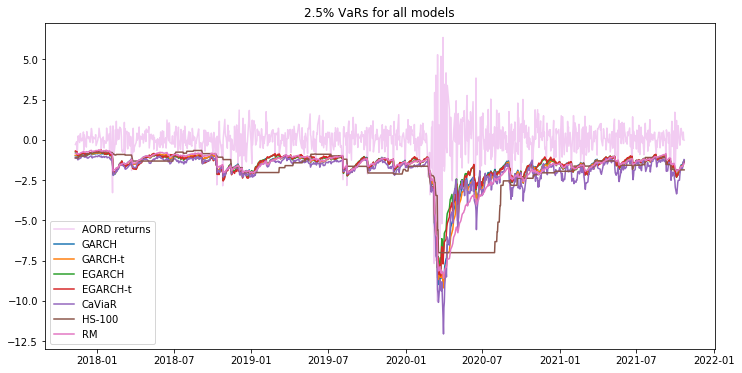

In [34]:
# 2.5% VaR forecasts
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(var25_garch, label='GARCH')
plt.plot(var25_garch_t, label='GARCH-t')
plt.plot(var25_egarch, label='EGARCH')
plt.plot(var25_egarch_t, label='EGARCH-t')
plt.plot(var25_caviar, label='CaViaR')
plt.plot(var25_hs100, label='HS-100')
plt.plot(var25_rm, label='RM')
plt.title('2.5% VaRs for all models')
plt.legend()
plt.show()

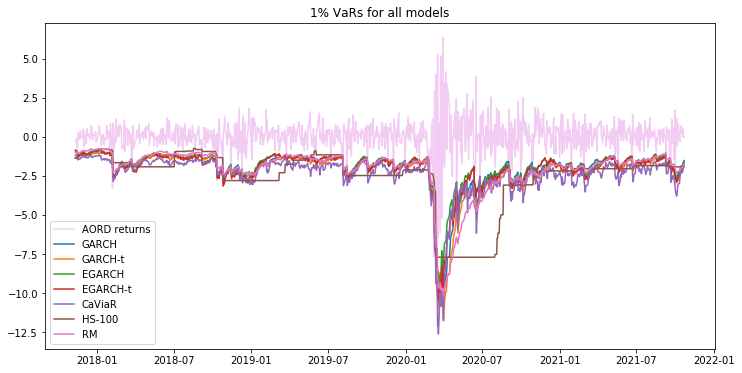

In [35]:
# 1% VaR forecasts
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(var1_garch, label='GARCH')
plt.plot(var1_garch_t, label='GARCH-t')
plt.plot(var1_egarch, label='EGARCH')
plt.plot(var1_egarch_t, label='EGARCH-t')
plt.plot(var1_caviar, label='CaViaR')
plt.plot(var1_hs100, label='HS-100')
plt.plot(var1_rm, label='RM')
plt.title('1% VaRs for all models')
plt.legend()
plt.show()

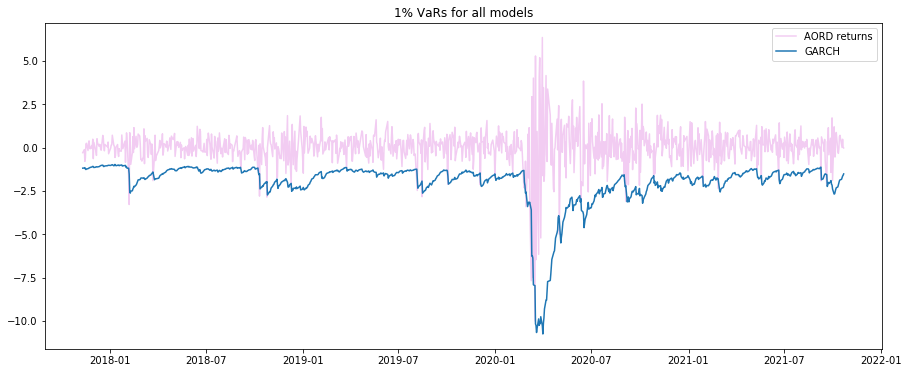

In [37]:
# 1% VaR forecasts
plt.figure(figsize=(15, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(var1_garch, label='GARCH')
plt.title('1% VaRs for all models')
plt.legend()
plt.show()

#### (d) Assess the accuracy and independence and loss function values of the models at forecasting the 2.5th and 1st quantiles for the All Ordinaries Index.

In [23]:
# Violations (hits)
hit25_garch = r_ao[frst_fc:] < var25_garch
hit1_garch = r_ao[frst_fc:] < var1_garch

hit25_garch_t = r_ao[frst_fc:] < var25_garch_t
hit1_garch_t = r_ao[frst_fc:] < var1_garch_t

hit25_egarch = r_ao[frst_fc:] < var25_egarch
hit1_egarch = r_ao[frst_fc:] < var1_egarch

hit25_egarch_t = r_ao[frst_fc:] < var25_egarch_t
hit1_egarch_t = r_ao[frst_fc:] < var1_egarch_t

hit25_caviar = r_ao[frst_fc:] < var25_caviar
hit1_caviar = r_ao[frst_fc:] < var1_caviar

hit25_hs100 = r_ao[frst_fc:] < var25_hs100
hit1_hs100 = r_ao[frst_fc:] < var1_hs100

hit25_rm = r_ao[frst_fc:] < var25_rm
hit1_rm = r_ao[frst_fc:] < var1_rm

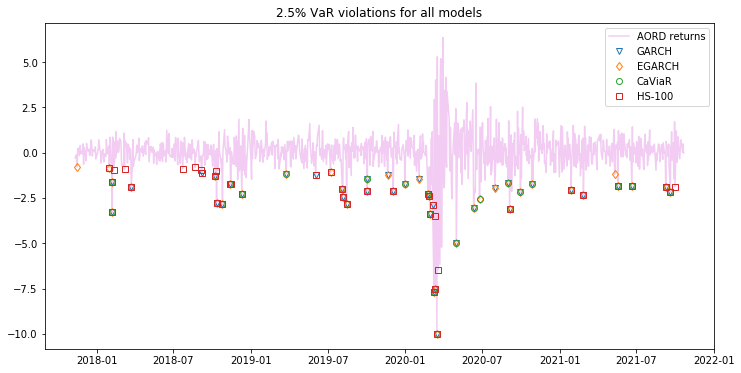

In [38]:
# 2.5% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(r_ao[frst_fc:][hit25_garch], 'v', mfc='none', label='GARCH')
plt.plot(r_ao[frst_fc:][hit25_egarch], 'd', mfc='none', label='EGARCH')
plt.plot(r_ao[frst_fc:][hit25_caviar], 'o', mfc='none', label='CaViaR')
plt.plot(r_ao[frst_fc:][hit25_hs100], 's', mfc='none', label='HS-100')
plt.title('2.5% VaR violations for all models')
plt.legend()
plt.show()

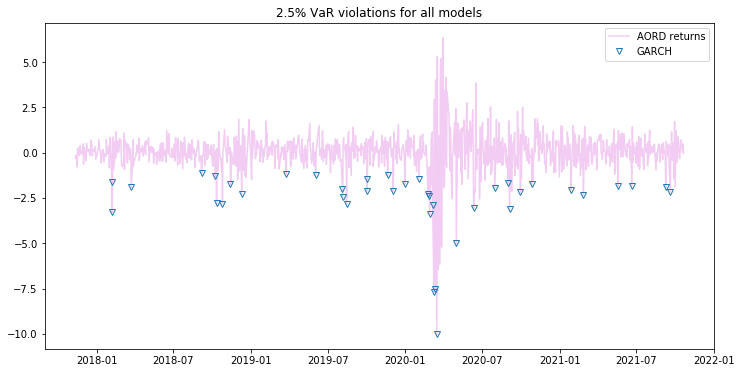

In [39]:
# 2.5% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(r_ao[frst_fc:][hit25_garch], 'v', mfc='none', label='GARCH')
plt.title('2.5% VaR violations for all models')
plt.legend()
plt.show()

In [25]:
# Unconditional coverage test
def uctest(hit, a):
    n = len(hit)
    p = np.sum(hit) / n
    z = (p - a) / np.sqrt(a * (1 - a) / n)
    pval = 2 * stats.norm.sf(np.abs(z))
    return pval, p

# Independence test
def indtest(hits):
    n = len(hits)

    r5 = hits.values[1:]
    r51 = hits.values[:-1]
    i11 = r5*r51
    i01 = r5*(1-r51)
    i10 = (1-r5)*r51
    i00 = (1-r5)*(1-r51)

    t00 = np.sum(i00)
    t01 = np.sum(i01)
    t10 = np.sum(i10)
    t11 = np.sum(i11)
    p01 = t01/(t00+t01)
    p11 = t11/(t10+t11)
    p1 = (t01+t11)/n

    ll1 = t00 * np.log(1-p01) + (p01>0) * t01 * np.log(p01) + t10 * np.log(1-p11)
    if p11>0:
        ll1=ll1+t11*np.log(p11)
  
    ll0=(t10+t00)*np.log(1-p1)+(t01+t11)*np.log(p1)

    lrind=2*(ll1-ll0)
    pcc=1-stats.chi2.cdf(lrind,1)
    return pcc, lrind

# Dynamic quantile test
def dqtest(y,f,a,lag):
    n = len(y)
    hits = ((y<f)*1)*(1-a)
    hits = (hits)*1+(y>f)*(-a)
    q=2+lag
    
    if np.sum((y<f)*1) > 0:
        ns = n - lag
        xmat = np.column_stack([np.ones((ns,1)), f[lag:n+1]])
        for k in range(1,lag+1):
            lk = lag-k
            xmat = np.column_stack([xmat, hits[lk:n-k]])
    
        hx = np.dot((hits[lag:n+1]), xmat)
        xtx = np.linalg.lstsq(np.matmul(xmat.T, xmat), np.eye(q), rcond = None)[0]
        dq = np.dot(np.dot(hx, xtx), hx.T)
        dq = dq/(a*(1-a))
        pdq = 1 - stats.chi2.cdf(dq,q)
    else:
        pdq = np.nan
        dq = np.nan
    return pdq, dq

# Quantile loss function
def qloss(q,r,p):
    q = np.array(q)
    x1 = r[r > q]
    x2 = r[r < q]
    f1 = q[r > q]
    f2 = q[r < q]
    l = p * np.sum(x1-f1) + (1-p) * np.sum(f2-x2)
    return l

# Accuracy checks
def check_var_fc(var_fc, r, p):
    hit = r < var_fc
    n_hit = np.sum(hit)
    pval_uc, p_hat = uctest(hit, p)
    pval_ind = indtest(hit)[0]
    pval_dq = dqtest(r, var_fc, p, 4)[0]
    qtl_loss = qloss(var_fc, r, p)
    return [n_hit, p_hat, p_hat / p, pval_uc, pval_ind, pval_dq, qtl_loss]

In [26]:
# 2.5% VaR forecast accuracy checks
tbl_var25 = pd.DataFrame({
    'G-N': check_var_fc(var25_garch, r_ao[frst_fc:], 0.025),
    'EG-N': check_var_fc(var25_egarch, r_ao[frst_fc:], 0.025),
    'G-t': check_var_fc(var25_garch_t, r_ao[frst_fc:], 0.025),
    'EG-t': check_var_fc(var25_egarch_t, r_ao[frst_fc:], 0.025),
    'CaViaR': check_var_fc(var25_caviar, r_ao[frst_fc:], 0.025),
    'HS100': check_var_fc(var25_hs100, r_ao[frst_fc:], 0.025),
    'IGARCH': check_var_fc(var25_rm, r_ao[frst_fc:], 0.025)},
    index=['Viol. (25)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_var25.round(4)

,G-N,EG-N,G-t,EG-t,CaViaR,HS100,IGARCH
Viol. (25),40.0000,42.0000,41.0000,45.0000,35.0000,41.0000,39.0000
$\hat{p}$,0.0400,0.0420,0.0410,0.0450,0.0350,0.0410,0.0390
$\hat{p}/p$,1.6000,1.6800,1.6400,1.8000,1.4000,1.6400,1.5600
UC,0.0024,0.0006,0.0012,0.0001,0.0428,0.0012,0.0046
Ind,0.0921,0.3741,0.1084,0.5015,0.1559,0.0010,0.0005
DQ,0.0044,0.0162,0.0021,0.0064,0.0213,0.0000,0.0000
Loss,78.3467,76.9636,78.6237,76.9515,77.1301,93.3782,80.0698


#### Answer guide
For 1-day-ahead VaR 2.5% forecasting for AORD returns, the CaViar model had the most accurate violation rate of 0.035, thogh this was still 40% above the desired 0.025. All models failed the UC test, i.e. all models had violation rates significantly different (clearly higher) than 0.025. All models also failed the DQ test, indicating their violations are also correlated over time. The violations plot below shows some clear clustering of all models violations, especially in early 2018, mid-2019 and early 2020.

The loss function results favoured the EGARCH-t, EGARCH-N and CaViar models, in that order. 

All models tried can be rejected here!

I would suggest to add the GJR-t model as potentially better model. We will also add SP500 as a regressor in Tutorial 13 to see if that improves things for the AORD.

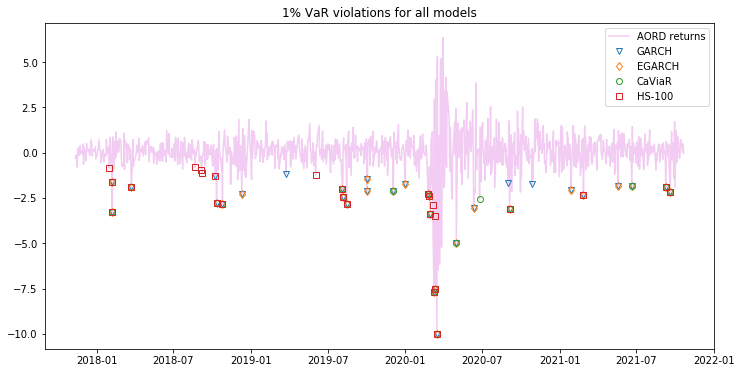

In [27]:
# 1% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(r_ao[frst_fc:][hit1_garch], 'v', mfc='none', label='GARCH')
plt.plot(r_ao[frst_fc:][hit1_egarch], 'd', mfc='none', label='EGARCH')
plt.plot(r_ao[frst_fc:][hit1_caviar], 'o', mfc='none', label='CaViaR')
plt.plot(r_ao[frst_fc:][hit1_hs100], 's', mfc='none', label='HS-100')
plt.title('1% VaR violations for all models')
plt.legend()
plt.show()

In [28]:
# 1% VaR forecast accuracy checks
tbl_var1 = pd.DataFrame({
    'G-N': check_var_fc(var1_garch, r_ao[frst_fc:], 0.01),
    'EG-N': check_var_fc(var1_egarch, r_ao[frst_fc:], 0.01),
    'G-t': check_var_fc(var1_garch_t, r_ao[frst_fc:], 0.01),
    'EG-t': check_var_fc(var1_egarch_t, r_ao[frst_fc:], 0.01),
    'CaViaR': check_var_fc(var1_caviar, r_ao[frst_fc:], 0.01),
    'HS100': check_var_fc(var1_hs100, r_ao[frst_fc:], 0.01),
    'IGARCH': check_var_fc(var1_rm, r_ao[frst_fc:], 0.01)},
    index=['Viol. (10)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_var1.round(4)

,G-N,EG-N,G-t,EG-t,CaViaR,HS100,IGARCH
Viol. (10),32.0000,28.0000,27.0000,27.0000,19.0000,26.0000,30.0000
$\hat{p}$,0.0320,0.0280,0.0270,0.0270,0.0190,0.0260,0.0300
$\hat{p}/p$,3.2000,2.8000,2.7000,2.7000,1.9000,2.6000,3.0000
UC,0.0000,0.0000,0.0000,0.0000,0.0042,0.0000,0.0000
Ind,0.0970,0.0457,0.2032,0.0370,0.3701,0.0003,0.0678
DQ,0.0000,0.0000,0.0000,0.0000,0.0035,0.0000,0.0000
Loss,43.8591,43.5346,41.4872,41.2833,34.9935,51.0422,46.6706


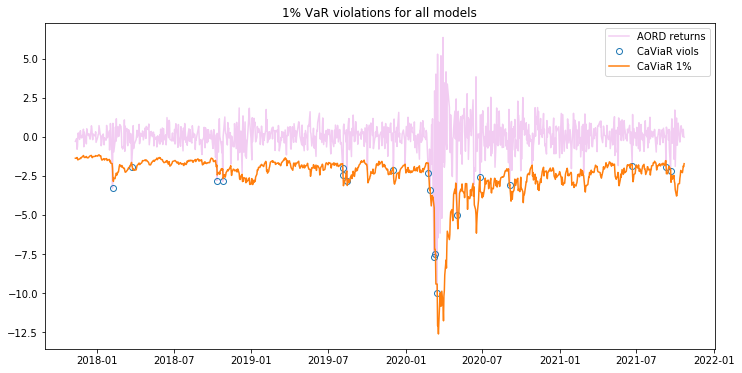

In [29]:
# 1% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(r_ao[frst_fc:][hit1_caviar], 'o', mfc='none', label='CaViaR viols')
plt.plot(var1_caviar, label='CaViaR 1%')
plt.title('1% VaR violations for all models')
plt.legend()
plt.show()

#### Answer guide
For 1-day-ahead VaR 1% forecasting for AORD returns, the CaViar model again has the most accurate violation rate of 0.019, though this was still 90% above the desired 0.01. All models again failed the UC test, i.e. all models had violation rates significantly different (clearly higher) than 0.01. All models again also failed the DQ test, indicating their violations are also correlated over time. The violations plot above shows some clear clustering of the CaViar model 1% violations, especially in mid-2019 and early 2020.

The loss function results clearly favoured the CaViar model only. 

All models tried can be rejected here!

I would suggest to add the GJR-t model as a potentially better model. We will also add SP500 as a regressor in Tutorial 13 to see if that improves things for the AORD VaR forecasting!